## Detection using YOLO

To start, we will grab the YOLO weights (pre trained model):

In [8]:
import requests
r = requests.get("https://pjreddie.com/media/files/yolov3.weights")  
with open('assets/yolov3.weights', 'wb') as f:
    f.write(r.content)


This will take a while!  It's a large file.  There is no indication it is working, either (because I didn't install a progress widget).  To verify it is done, see if it exists in the `/assets` folder.  It will be the file `yolov3.weights`.

In [36]:
import cv2
import numpy as np

We will make some helper functions.  We can also put these in a python lib file.

In [37]:
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [38]:
image = cv2.imread("images/example.jpg")

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

classes = None

with open("assets/yolov3.classes.txt", 'r') as f:
    classes = [line.strip() for line in f.readlines()]
    
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNet("assets/yolov3.weights", "assets/yolov3.cfg")

blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))



And now we will plot our detection.

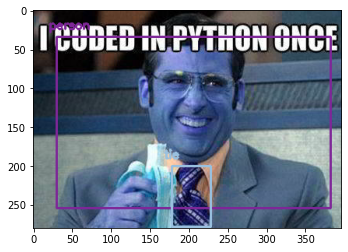

In [39]:
from matplotlib import pyplot as plt
plt.imshow(image)

In [40]:
from IPython.display import display, Markdown, Latex
display(Markdown("This will generate some markdown for reporting."))
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
#     draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
    display(Markdown(f"We were able to detect a `{(classes[class_ids[i]])}` with a confidence of `{round(confidences[i],2)*100}%`"))

This will generate some markdown for reporting.

We were able to detect a `person` with a confidence of `100.0%`

We were able to detect a `tie` with a confidence of `83.0%`